## The Data
### we are using Population Time Series Data
Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.

In [40]:


# Carregando pacotes
import numpy as np                               # Vetores e matrizes
import pandas as pd                              # Tabelas e manipulações de dados
import matplotlib.pyplot as plt                  # graficos
import seaborn as sns                            # mais graficos
import warnings                                  # mode não pertube
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

from dateutil.relativedelta import relativedelta # trabalhando com datas e estilos
from scipy.optimize import minimize              # para funções de otimização

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                   
from tqdm import tqdm_notebook


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [41]:
from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    
from tqdm import tqdm_notebook
import matplotlib
matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'




In [42]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [43]:
ads = pd.read_csv("POP.csv", index_col=['date'], parse_dates=['date'])



In [44]:
ads.head()

,realtime_start,value,realtime_end
date,,,
1952-01-01,2019-12-06,156309.0,2019-12-06
1952-02-01,2019-12-06,156527.0,2019-12-06
1952-03-01,2019-12-06,156731.0,2019-12-06
1952-04-01,2019-12-06,156943.0,2019-12-06
1952-05-01,2019-12-06,157140.0,2019-12-06


In [45]:
col=["realtime_start", "realtime_end"]
ads.drop(col, axis=1,inplace=True)

In [46]:
ads.head()

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


In [47]:
ads.shape
ads.describe()

,value
count,816.000000
mean,243847.767826
std,50519.140567
min,156309.000000
25%,201725.250000
50%,239557.500000
75%,289364.250000
max,330309.946000


In [48]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 816 entries, 1952-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   816 non-null    float64
dtypes: float64(1)
memory usage: 12.8 KB


In [49]:
#valores nulos
ads.isnull().sum()

value    0
dtype: int64

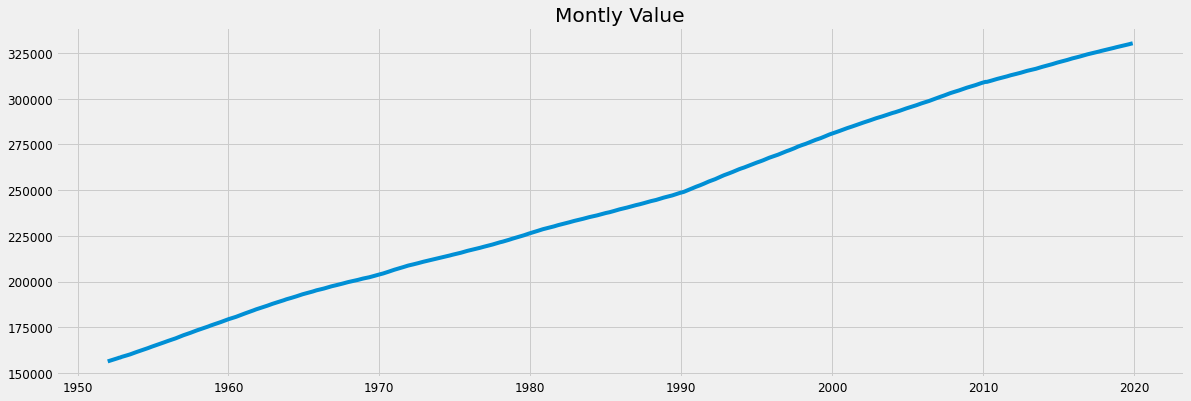

In [50]:
plt.figure(figsize=(18, 6))
plt.plot(ads)
plt.title("Montly Value")
plt.show()

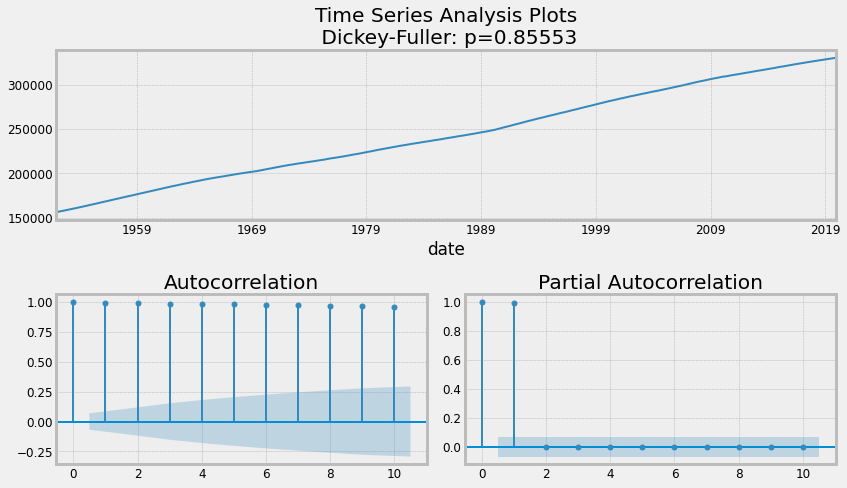

In [51]:

#Forte tendencia
tsplot(ads.value,lags=10)



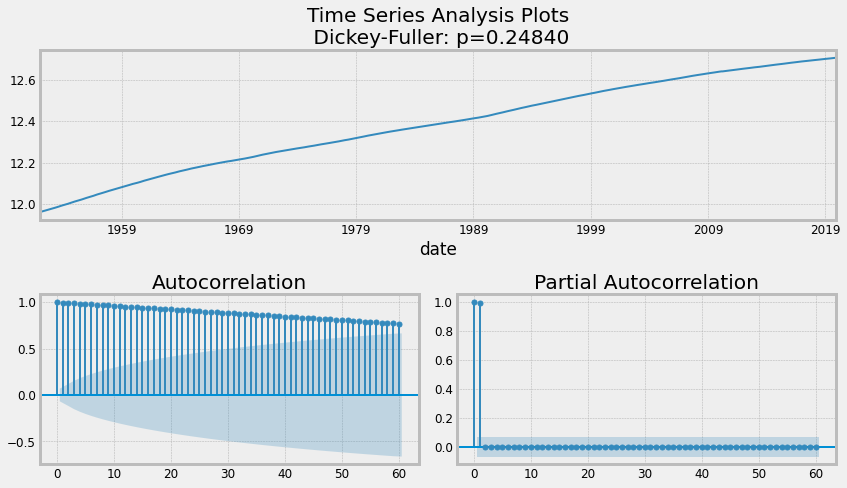

In [52]:
ads_log=np.log(ads.value)
tsplot(ads_log,lags=60)

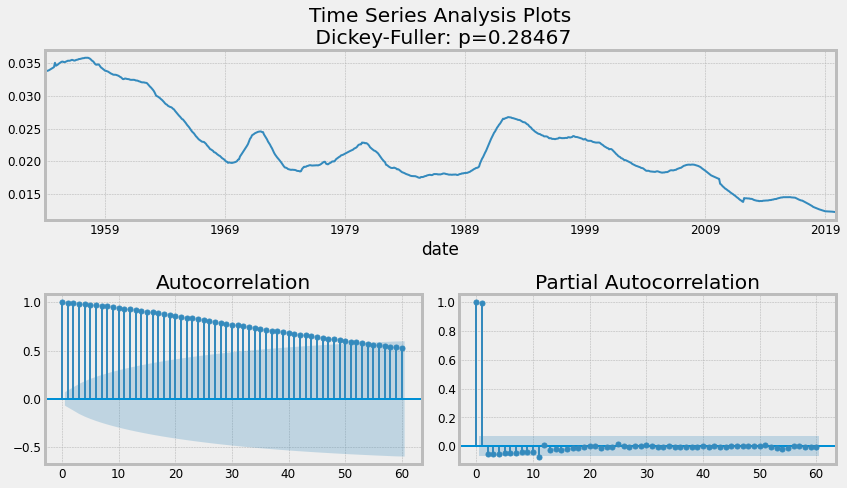

In [53]:
# A diferença de dias!
ads_log_diff = ads_log - ads_log.shift(24)
tsplot(ads_log_diff[24:], lags=60)

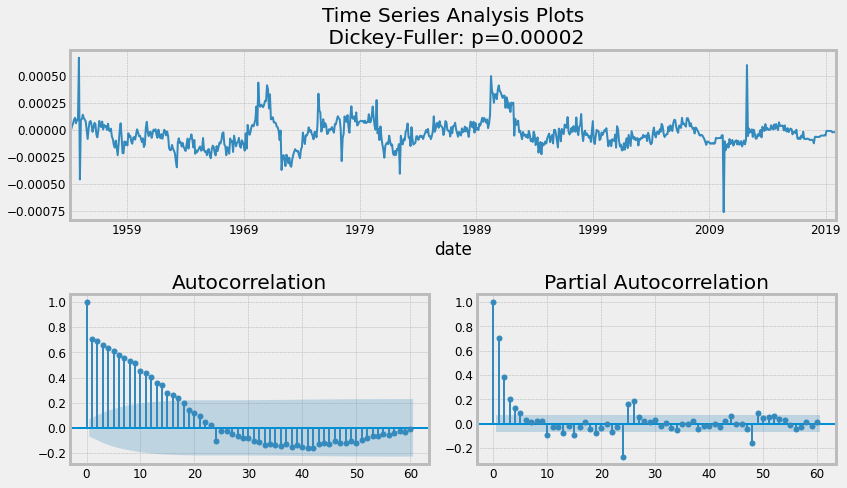

In [54]:
ads_log_diff = ads_log_diff - ads_log_diff.shift(1)
tsplot(ads_log_diff[24+1:], lags = 60)

### We can use decomposition Method to plot distinct the tree component of the Time Serie: Trend, Saisonality and noise
we cann see that, there is no saisonality

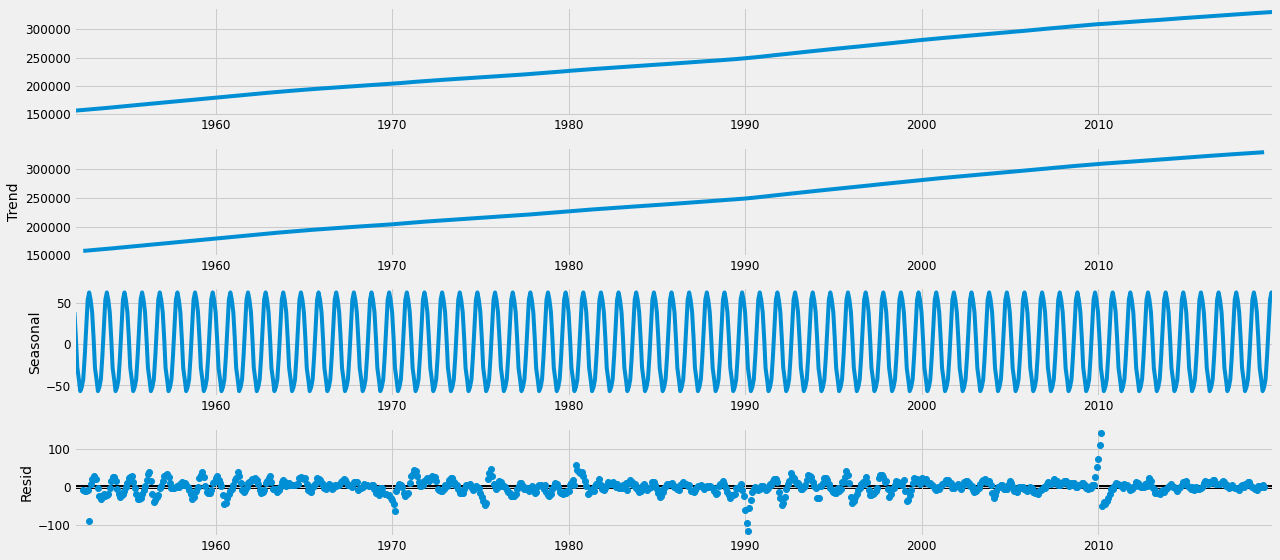

In [55]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ads, model='additive')
fig = decomposition.plot()
plt.show()

### Function the search the parameters q,p,Q,P for SARIMA-Model

In [56]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 #first Differencing
qs = range(2, 5)
Ps = range(0, 2)
D=1 #second Differecing
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)#List of ARIMA Parameter
len(parameters_list)#Lenght of the List


def optimizeSARIMA(y, parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table



In [57]:
%%time
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(ads, parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

Wall time: 6min 52s


In [58]:
#Parameter and AIC
result_table.head()
min(result_table.aic)

6625.97982030831

In [59]:
# setando os parametros lowest AIC
#The Best Model has the parameter (2,1,2)(0,1,1,24)
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.value, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                  816
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 24)   Log Likelihood               -3306.990
Date:                              Tue, 16 Nov 2021   AIC                           6625.980
Time:                                      09:24:18   BIC                           6654.020
Sample:                                  01-01-1952   HQIC                          6636.757
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2807      2.187      0.128      0.898      -4.006       4.567
ar.L2          0.69

In [60]:
mod=sm.tsa.statespace.SARIMAX(ads, order=(3, 1, 2), 
                                        seasonal_order=(0, 1, 1, 24),
                             enforce_stationarity=False,
                             enforce_invertibility=False)

#Fitting do modelo
result=mod.fit()

In [61]:
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6136      0.470      1.307      0.191      -0.307       1.534
ar.L2          0.3688      0.463      0.797      0.426      -0.539       1.276
ar.L3         -0.0012      0.001     -1.510      0.131      -0.003       0.000
ma.L1         -0.2110      0.470     -0.449      0.653      -1.132       0.710
ma.L2         -0.2479      0.281     -0.882      0.378      -0.798       0.303
ma.S.L24      -0.8010      0.019    -42.083      0.000      -0.838      -0.764
sigma2       223.8432      2.430     92.119      0.000     219.081     228.606


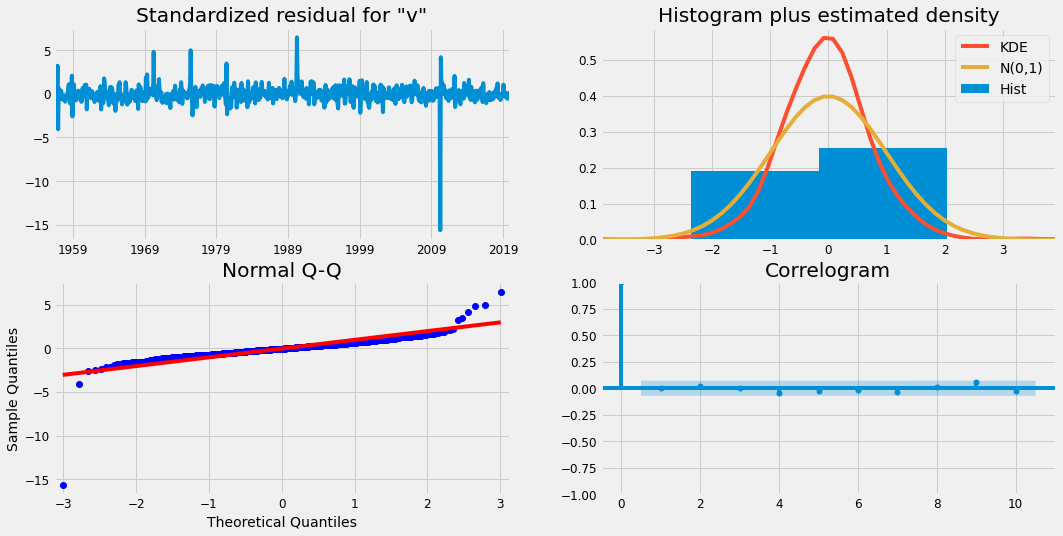

In [62]:
result.plot_diagnostics(figsize=(16, 8))
plt.show()

## Model diagnostic to investigate any ununsual issues
#### The Residual has a normal Distribution, that mean that our Model is god

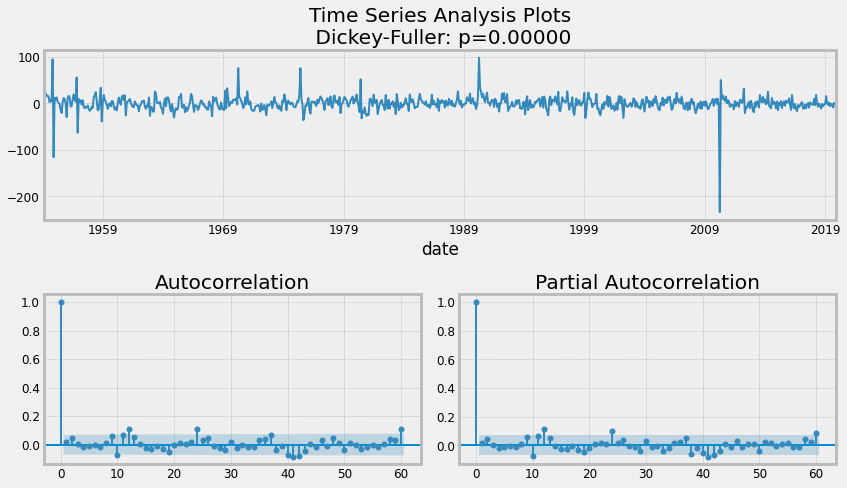

In [63]:

tsplot(best_model.resid[24+1:], lags=60)

In [64]:
def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adicionando os valores no modelo
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # projetando os dados a partir dos meses/anos 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculando o erro em cima do passos!
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    

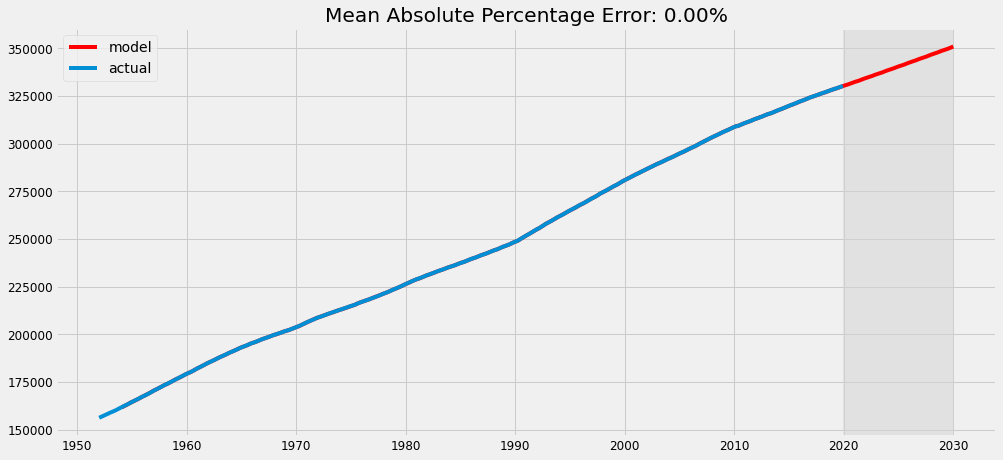

In [65]:
#Forecast para 120 dias
plotSARIMA(ads, best_model, 120)

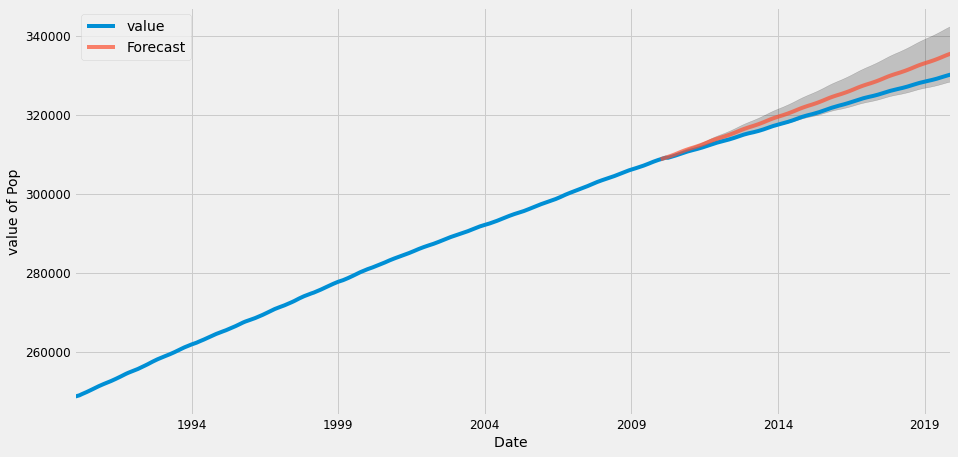

In [66]:

pred = result.get_prediction(start=pd.to_datetime('2010-01-01'),dynamic=True)
pred_ci= pred.conf_int()
ax = ads['1990':].plot(label='observed')
pred.predicted_mean.plot(ax = ax, label='Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date ')
ax.set_ylabel('value of Pop')
plt.legend()
plt.show()

### Forecasts visualizition

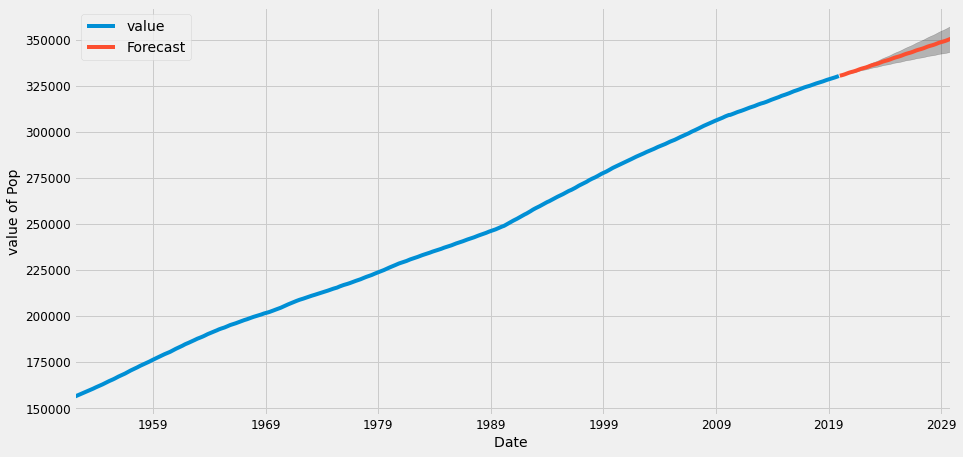

In [67]:

pred_u=result.get_forecast(steps=120)
pred_ci= pred_u.conf_int()
ax = ads.plot(label='observed',figsize=(14, 7))
pred_u.predicted_mean.plot(ax = ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date ')
ax.set_ylabel('value of Pop')
plt.legend()
plt.show()

In [68]:
#Valores da predição
pred_ci

,lower value,upper value
2020-01-01,330432.101599,330490.749177
2020-02-01,330547.080091,330648.105238
2020-03-01,330658.673731,330803.549404
2020-04-01,330768.054701,330959.875938
2020-05-01,330895.322749,331137.043429
...,...,...
2029-08-01,343129.500356,356581.994995
2029-09-01,343258.112631,356868.396732
2029-10-01,343382.846919,357151.117692
2029-11-01,343485.826875,357412.260202
